# Stock Market Prediction using GRU

This notebook performs stock market prediction using a **Gated Recurrent Unit (GRU)** model.
It includes the following steps:
- Data Collection (Using `yfinance`)
- Data Preprocessing
- Exploratory Data Analysis (EDA)
- Feature Engineering
- Training a GRU Model
- Predicting Stock Prices for the Next 10 Days
- Model Evaluation

**Dataset:** Latest stock data, starting from 10 days before today.


In [2]:
# Import required libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout

# Set plot style
# plt.style.use("seaborn-darkgrid")


In [3]:
# Fetch stock data (10 days before today)
stock_symbol = "AAPL"  # Change to any stock ticker
data = yf.download(stock_symbol, period="5y", interval="1d")

# Display first few rows
data.head()


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-02-18,77.414604,77.596613,76.349240,76.531249,152531200
2020-02-19,78.535782,78.766330,77.657285,77.657285,93984000
2020-02-20,77.730087,78.785743,77.222889,78.295534,100566000
2020-02-21,75.970680,77.766511,75.351852,77.322404,129554000
2020-02-24,72.362038,73.818112,70.190065,72.138777,222195200


In [4]:
# Extract only the closing prices
closing_prices = data[['Close']]

# Normalize data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(closing_prices)

# Add Moving Averages (Feature Engineering)
data['SMA_50'] = data['Close'].rolling(window=50).mean()
data['SMA_200'] = data['Close'].rolling(window=200).mean()

# Drop NA values
data.dropna(inplace=True)

# Display data with new features
data.head()


Price,Close,High,Low,Open,Volume,SMA_50,SMA_200
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,
Date,,,,,,,
2020-11-30,116.285789,118.161207,114.097795,114.254083,169410200,113.018417,91.938505
2020-12-01,119.870575,120.603161,117.223499,118.200280,127728200,113.269050,92.150785
2020-12-02,120.222214,120.505481,118.083061,119.186821,89004200,113.492979,92.359217
2020-12-03,120.085480,120.905972,119.372426,120.652007,78967600,113.805637,92.570994
2020-12-04,119.411476,120.007313,118.698423,119.753348,78260400,114.083363,92.788198


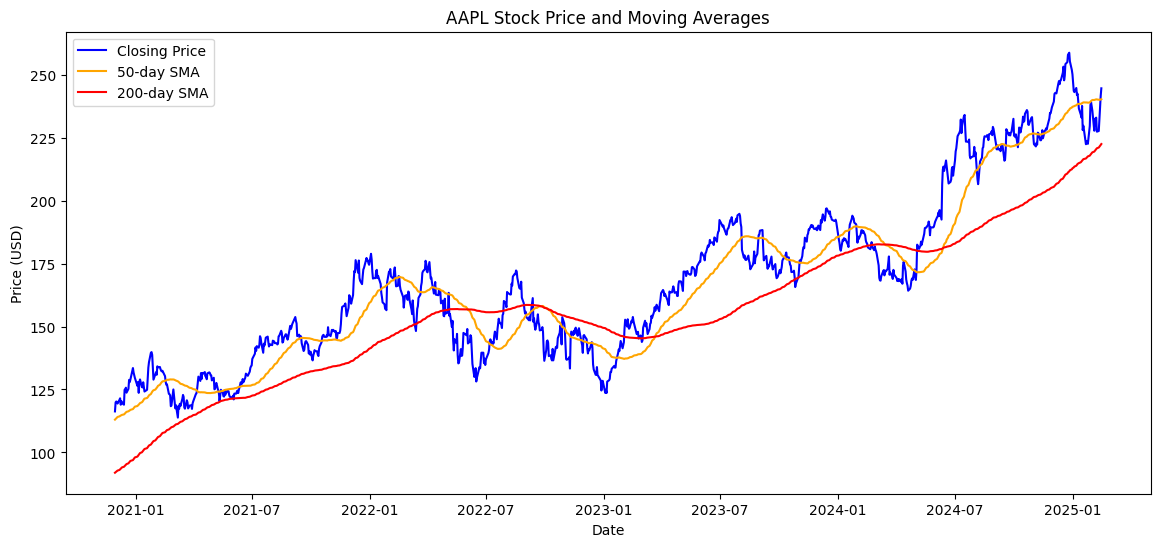

In [5]:
# Visualizing Stock Price and Moving Averages
plt.figure(figsize=(14,6))
plt.plot(data['Close'], label="Closing Price", color='blue')
plt.plot(data['SMA_50'], label="50-day SMA", color='orange')
plt.plot(data['SMA_200'], label="200-day SMA", color='red')
plt.title(f"{stock_symbol} Stock Price and Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()


In [6]:
# Function to create sequences for training
def create_sequences(data, time_steps=100):
    X, y = [], []
    for i in range(len(data) - time_steps - 10):  # Reserve last 10 days for future prediction
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])  # Next day as target
    return np.array(X), np.array(y)

# Create sequences
time_steps = 100
X, y = create_sequences(scaled_data, time_steps)

# Reshape data for GRU model
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split into training and test sets (80-20 split)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [11]:
# # Build the GRU model
# model = Sequential([
#     GRU(50, return_sequences=True, input_shape=(time_steps, 1)),
#     Dropout(0.2),
#     GRU(50, return_sequences=False),
#     Dropout(0.2),
#     Dense(25),
#     Dense(1)  # Output layer
# ])

# # Compile the model
# model.compile(optimizer='adam', loss='mean_squared_error')

# # Train the model
# history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test))

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, LSTM, Dense, Dropout

def create_lstm_model(input_shape, dropout_rate):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        Dropout(dropout_rate),
        LSTM(50, return_sequences=False),
        Dropout(dropout_rate),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def create_gru_model(input_shape, dropout_rate):
    model = Sequential([
        GRU(50, return_sequences=True, input_shape=input_shape),
        Dropout(dropout_rate),
        GRU(50, return_sequences=False),
        Dropout(dropout_rate),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [12]:
# Get LSTM model and get summary of the model.
lstm_model = create_lstm_model(input_shape=(time_steps, 1), dropout_rate=0.2)
lstm_model.summary()
# Get GRU model and get summary of it.
gru_model = create_gru_model(input_shape=(time_steps, 1), dropout_rate=0.2)
gru_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 100, 50)             │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 100, 50)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                          │ (None, 100, 50)             │           7,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 100, 50)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ (None, 50)                  │          15,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,551 (95.90 KB)

 Trainable params: 24,551 (95.90 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Train LSTM and GRU model one by one
# Separate it with big horizontal line
print("=====================================================================")
print("Training LSTM model...")
lstm_model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test))
print("=====================================================================")
print("Training GRU model...")
gru_model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test))
print("=====================================================================")

Training LSTM model...
Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 118ms/step - loss: 0.0574 - val_loss: 0.0047
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - loss: 0.0043 - val_loss: 0.0142
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - loss: 0.0034 - val_loss: 0.0090
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - loss: 0.0026 - val_loss: 0.0054
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - loss: 0.0025 - val_loss: 0.0028
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - loss: 0.0021 - val_loss: 0.0026
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - loss: 0.0021 - val_loss: 0.0033
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - loss: 0.0024 - val_loss: 0.0012
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - loss: 0.0019 - val_loss: 0.0028
Epoch 12/50
29/29 ━━━━━━━━━━━━

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
LSTM Model:
Root Mean Squared Error: 0.026445663305145608
R² Score: 0.956099927529208

GRU Model:
Root Mean Squared Error: 0.018711614714643297
R² Score: 0.9780224720349452


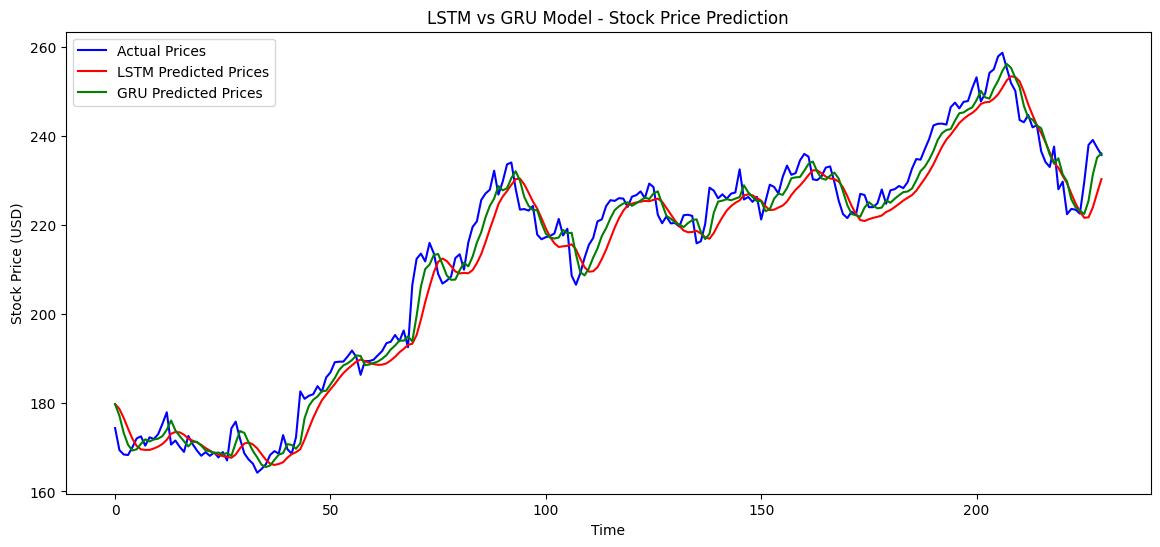

In [16]:
lstm_predictions = lstm_model.predict(X_test)
gru_predictions = gru_model.predict(X_test)
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# Convert predictiond back to original scale
lstm_predicted_prices = scaler.inverse_transform(lstm_predictions)
gru_predicted_prices = scaler.inverse_transform(gru_predictions)

# Calculate error metrics
lstm_rmse = np.sqrt(mean_squared_error(y_test, lstm_predictions))
lstm_r2 = r2_score(y_test, lstm_predictions)
gru_rmse = np.sqrt(mean_squared_error(y_test, gru_predictions))
gru_r2 = r2_score(y_test, gru_predictions)

# Print results
print("LSTM Model:")
print(f"Root Mean Squared Error: {lstm_rmse}")
print(f"R² Score: {lstm_r2}")
print("\nGRU Model:")
print(f"Root Mean Squared Error: {gru_rmse}")
print(f"R² Score: {gru_r2}")

# Plot Actual vs Predicted prices
plt.figure(figsize=(14,6))
plt.plot(actual_prices, label="Actual Prices", color='blue')
plt.plot(lstm_predicted_prices, label="LSTM Predicted Prices", color='red')
plt.plot(gru_predicted_prices, label="GRU Predicted Prices", color='green')
plt.title("LSTM vs GRU Model - Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Stock Price (USD)")
plt.legend()
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step
Root Mean Squared Error: 3.944872763693648
R² Score: 0.9765929486521402


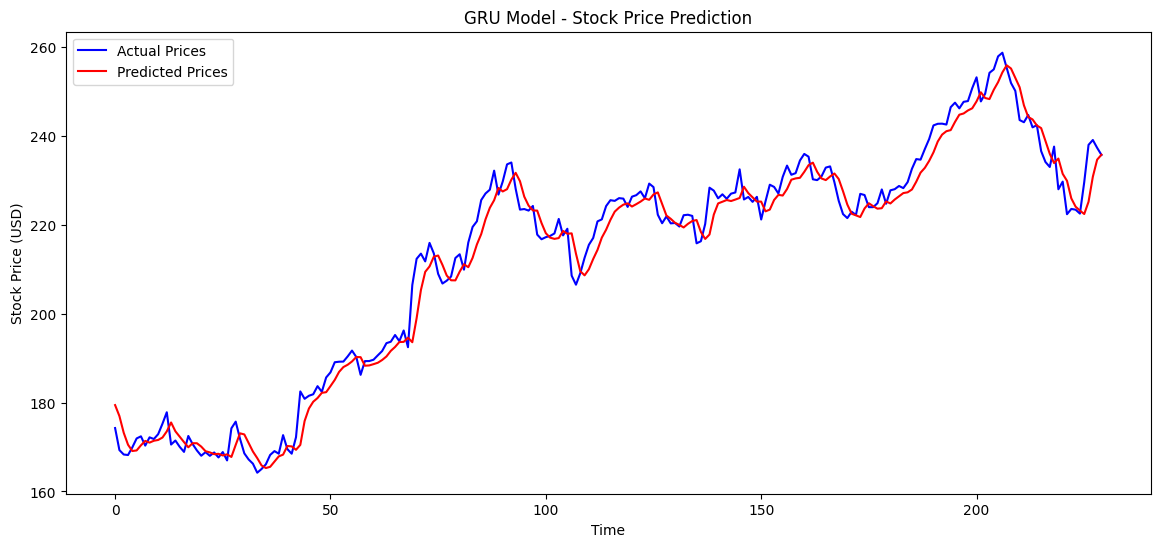

In [8]:
# # Predict stock prices on the test set
# predictions = model.predict(X_test)

# # Convert predictions back to original scale
# predicted_prices = scaler.inverse_transform(predictions)
# actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# # Calculate error metrics
# rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
# r2 = r2_score(actual_prices, predicted_prices)

# # Print results
# print(f"Root Mean Squared Error: {rmse}")
# print(f"R² Score: {r2}")

# # Plot Actual vs Predicted Prices
# plt.figure(figsize=(14,6))
# plt.plot(actual_prices, label="Actual Prices", color='blue')
# plt.plot(predicted_prices, label="Predicted Prices", color='red')
# plt.title("GRU Model - Stock Price Prediction")
# plt.xlabel("Time")
# plt.ylabel("Stock Price (USD)")
# plt.legend()
# plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Predicted Stock Prices for the Next 10 Days:
LSTM Model:
[234.0108  235.20645 235.58058 235.49391 235.13998 234.62389 234.00435
 233.31583 232.58005 231.81175]

GRU Model:
[240.47433 240.33691 239.84859 239.38885 238.92996 238.46251 237.988

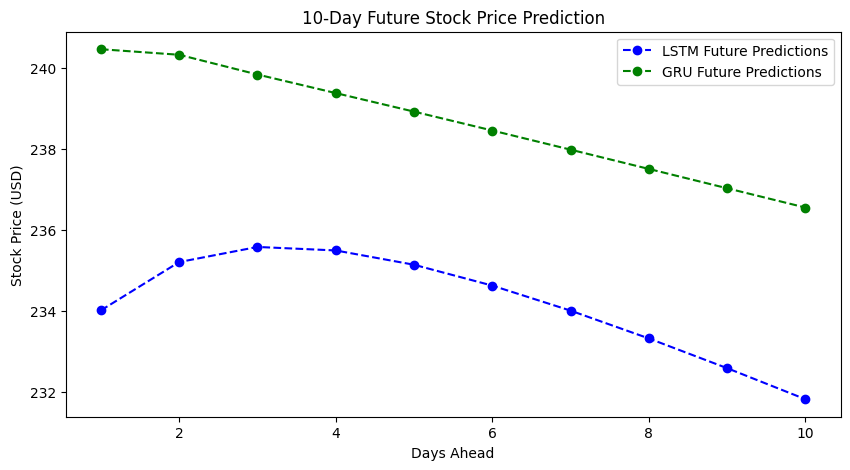

In [17]:
# Prepare the last 100 dats for future prediction
last_100_days_lstm = scaled_data[-100:].reshape(1, 100, 1)
last_100_days_gru = scaled_data[-100:].reshape(1, 100, 1)

# Predict next 10 days
future_prediction_lstm = []
future_prediction_gru = []
for _ in range(10):
    lstm_predicted = lstm_model.predict(last_100_days_lstm)[0][0]
    gru_predicted = gru_model.predict(last_100_days_gru)[0][0]
    future_prediction_lstm.append(lstm_predicted)
    future_prediction_gru.append(gru_predicted)
    last_100_days_lstm = np.append(last_100_days_lstm[:,1:,:], [[[lstm_predicted]]], axis=1)
    last_100_days_gru = np.append(last_100_days_gru[:,1:,:], [[[gru_predicted]]], axis=1)

# Conver future predictions back to original scale
future_prices_lstm = scaler.inverse_transform(np.array(future_prediction_lstm).reshape(-1,1))
future_prices_gru = scaler.inverse_transform(np.array(future_prediction_gru).reshape(-1,1))

# Display results
print("Predicted Stock Prices for the Next 10 Days:")
print("LSTM Model:")
print(future_prices_lstm.flatten())
print("\nGRU Model:")
print(future_prices_gru.flatten())

# Plot the future predictions
plt.figure(figsize=(10,5))
plt.plot(range(1,11), future_prices_lstm, marker='o', linestyle='dashed', color='blue', label="LSTM Future Predictions")
plt.plot(range(1,11), future_prices_gru, marker='o', linestyle='dashed', color='green', label="GRU Future Predictions")
plt.title("10-Day Future Stock Price Prediction")
plt.xlabel("Days Ahead")
plt.ylabel("Stock Price (USD)")
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Predicted Stock Prices for the Next 10 Days:
[240.0175  239.86931 239.35545 238.82042 238.29552 237.77405 237.25366
 236.73482 236.21855 235.70541]


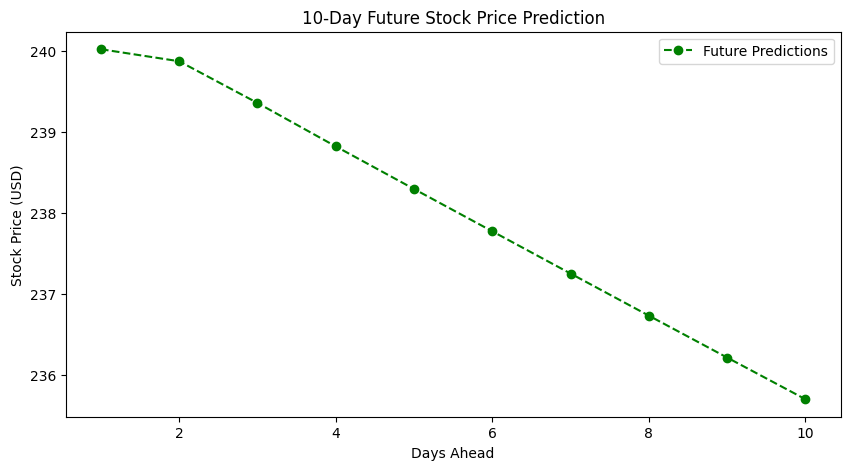

In [9]:
# Prepare the last 100 days for future prediction
last_100_days = scaled_data[-100:].reshape(1, 100, 1)

# Predict next 10 days
future_predictions = []
for _ in range(10):
    predicted = model.predict(last_100_days)[0][0]
    future_predictions.append(predicted)

    # Update input data (shift left and add new predicted value)
    last_100_days = np.append(last_100_days[:,1:,:], [[[predicted]]], axis=1)

# Convert future predictions back to original scale
future_prices = scaler.inverse_transform(np.array(future_predictions).reshape(-1,1))

# Display results
print("Predicted Stock Prices for the Next 10 Days:")
print(future_prices.flatten())

# Plot the future predictions
plt.figure(figsize=(10,5))
plt.plot(range(1,11), future_prices, marker='o', linestyle='dashed', color='green', label="Future Predictions")
plt.title("10-Day Future Stock Price Prediction")
plt.xlabel("Days Ahead")
plt.ylabel("Stock Price (USD)")
plt.legend()
plt.show()


Comparison of Actual vs. Predicted Prices:
   Actual Price  Predicted Price  Difference  Percentage Difference (%)
0    174.277084       179.668427   -5.391342                  -3.093546
1    169.320480       178.569580   -9.249100                  -5.462481
2    168.325180       176.550995   -8.225815                  -4.886859
3    168.205765       174.169022   -5.963257                  -3.545215
4    169.927628       171.902451   -1.974823                  -1.162155


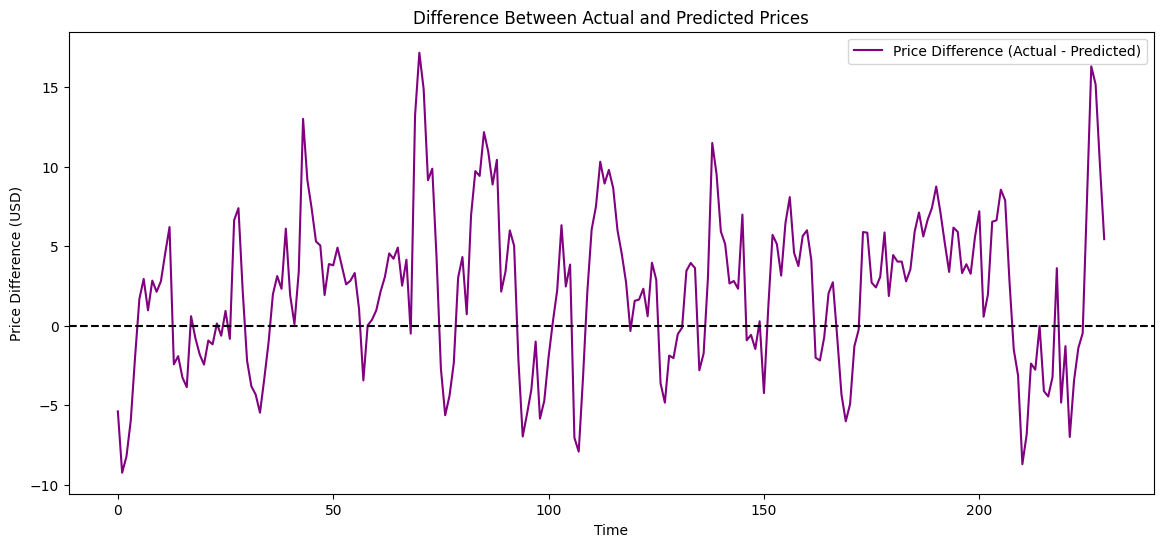

In [18]:
# Compute differences between actual and predicted prices
price_differences = actual_prices - lstm_predicted_prices
percentage_differences = (price_differences / actual_prices) * 100  # Percentage difference

# Convert to DataFrame for better visualization
comparison_df = pd.DataFrame({
    "Actual Price": actual_prices.flatten(),
    "Predicted Price": lstm_predicted_prices.flatten(),
    "Difference": price_differences.flatten(),
    "Percentage Difference (%)": percentage_differences.flatten()
})

# Display first few rows
print("Comparison of Actual vs. Predicted Prices:")
print(comparison_df.head())

# Plot the difference
plt.figure(figsize=(14,6))
plt.plot(price_differences, label="Price Difference (Actual - Predicted)", color='purple')
plt.axhline(y=0, color='black', linestyle='--')
plt.title("Difference Between Actual and Predicted Prices")
plt.xlabel("Time")
plt.ylabel("Price Difference (USD)")
plt.legend()
plt.show()


Comparison of Actual vs. Predicted Prices:
   Actual Price  Predicted Price  Difference  Percentage Difference (%)
0    174.277084       179.630142   -5.353058                  -3.071579
1    169.320480       177.054306   -7.733826                  -4.567567
2    168.325180       173.180298   -4.855118                  -2.884368
3    168.205765       170.525284   -2.319519                  -1.378977
4    169.927628       169.224976    0.702652                   0.413501


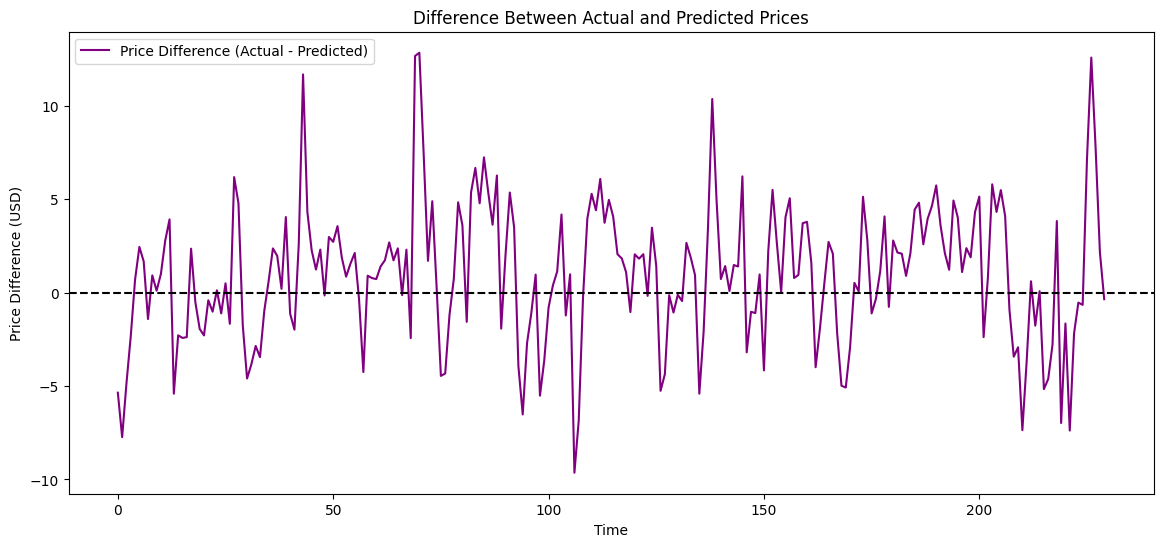

In [19]:
# Lets do the same price difference calculation for GRU
price_differences_gru = actual_prices - gru_predicted_prices
percentage_differences_gru = (price_differences_gru / actual_prices) * 100  # Percentage difference

# Convert them into dataframe for better visualization
comparison_df_gru = pd.DataFrame({
    "Actual Price": actual_prices.flatten(),
    "Predicted Price": gru_predicted_prices.flatten(),
    "Difference": price_differences_gru.flatten(),
    "Percentage Difference (%)": percentage_differences_gru.flatten()
})

# Display first few rows
print("Comparison of Actual vs. Predicted Prices:")
print(comparison_df_gru.head())

# Plot the difference
plt.figure(figsize=(14,6))
plt.plot(price_differences_gru, label="Price Difference (Actual - Predicted)", color='purple')
plt.axhline(y=0, color='black', linestyle='--')
plt.title("Difference Between Actual and Predicted Prices")
plt.xlabel("Time")
plt.ylabel("Price Difference (USD)")
plt.legend()
plt.show()